In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/PDFs")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/DetResponse")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/Utils")

from Detector import *
from Signal import *
from Plot_Histogram import *
from Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
MC = ExtractMC(['120000', '140000', '160000'])

In [5]:
Bin = Std_Binning(1000, N_Etrue=500)

In [6]:
def EffArea_MC(MCcut, Bin):
    Eff=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}

    for nu_type in nu_types:
        loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type])
                        # & (MCcut["E_reco"] < 1000)
                        # & (MCcut["E_reco"] > np.min(Bin["reco_energy_center"]))
                        # & (MCcut["E_true"] < 3100)
                        # & (MCcut["E_true"] > np.min(Bin["true_energy_center"]))
                        # & (MCcut["psi_true"] < np.max(Bin["true_psi_center"]))
                        # & (MCcut["psi_true"] > np.min(Bin["true_psi_center"]))
                        # & (psireco < np.max(Bin["reco_psi_center"]))
                        # & (psireco > np.min(Bin["reco_psi_center"]))
                        )

        #Extract MC events: 
        #NOTE: input psi in deg!
        psitrue = MCcut["psi_true"][loc]
        Etrue = MCcut["E_true"][loc]
        # psireco = psireco[loc]
        # Ereco = MCcut["E_reco"][loc]
        w = MCcut["w"][loc]        
        Eff[nu_type], edges =np.histogramdd((psitrue, Etrue),
                                bins = (Bin['true_psi_edges'], Bin['true_energy_edges']),
                                weights=w)
    return Eff

In [7]:
Eff_MC = EffArea_MC(MC, Bin)

/tmp/ipykernel_26064/2852331593.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Eff_MC['nu_e'], np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


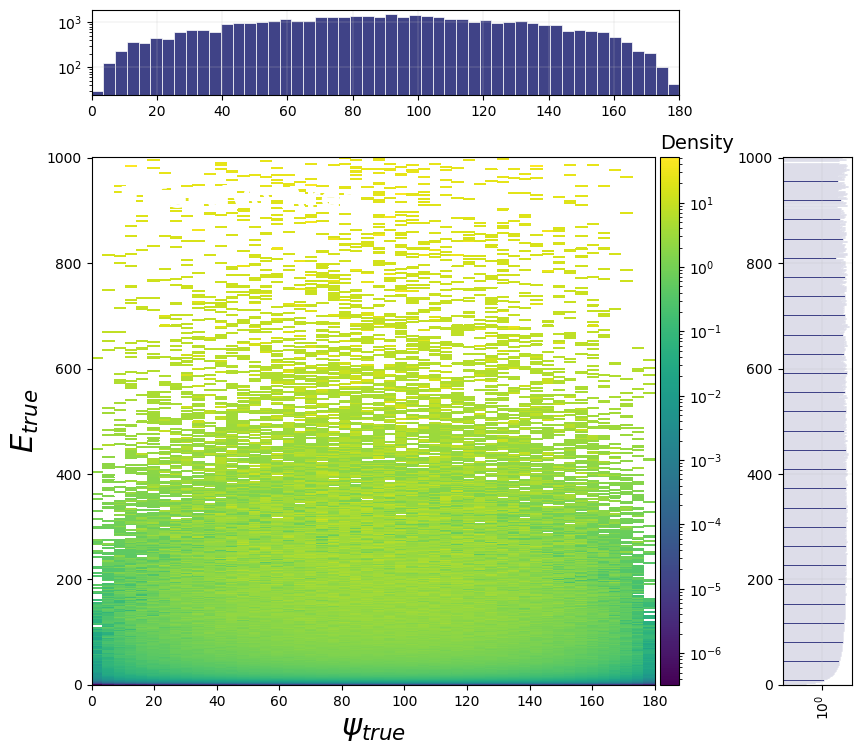

In [8]:
plot_projections(Eff_MC['nu_e'], np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


In [9]:
Reco = RecoRate('WW', 3000, 'NFW', Bin)
Resp_KDE = Reco.ComputeResp()

********************
Computing Response Matrix
********************
Accessing MC set 0000


/tmp/ipykernel_26064/282231919.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Resp_KDE['nu_e'].sum(axis=(2,3)), np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


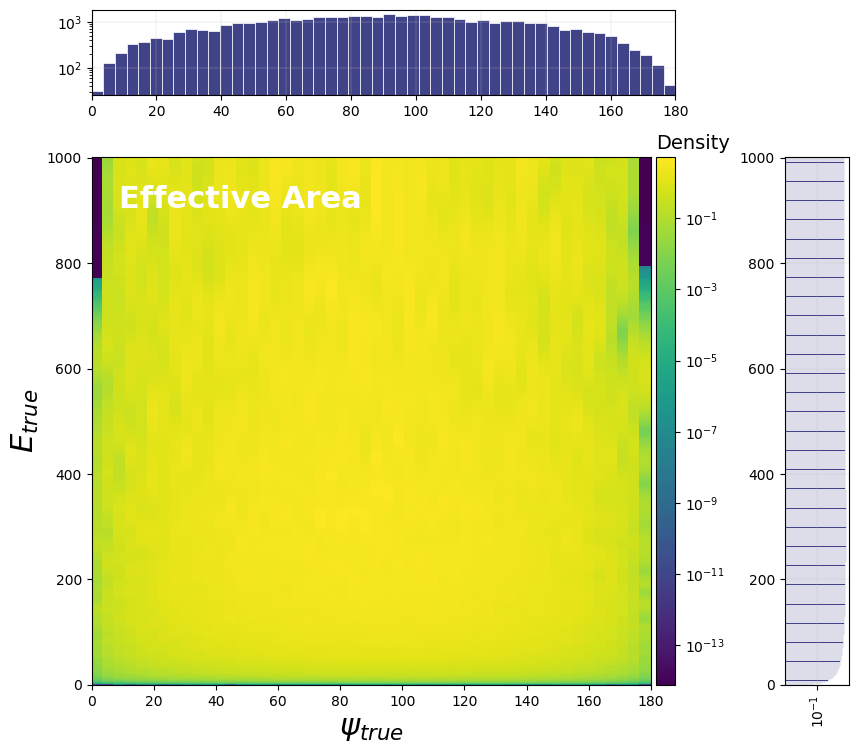

In [10]:
plot_projections(Resp_KDE['nu_e'].sum(axis=(2,3)), np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


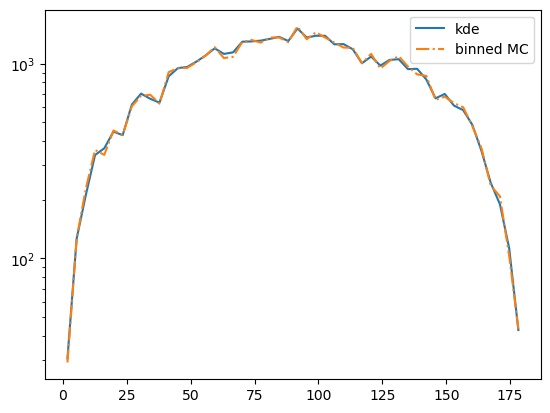

In [11]:
nu = 'nu_e'
Eff_kde_psi = Resp_KDE[nu].sum(axis=(1,2,3))
Eff_MC_psi = Eff_MC[nu].sum(axis=1)
plt.plot(Bin['true_psi_center'], Eff_kde_psi, label='kde')
plt.plot(Bin['true_psi_center'], Eff_MC_psi, label='binned MC',ls='-.')

plt.semilogy()
plt.legend()

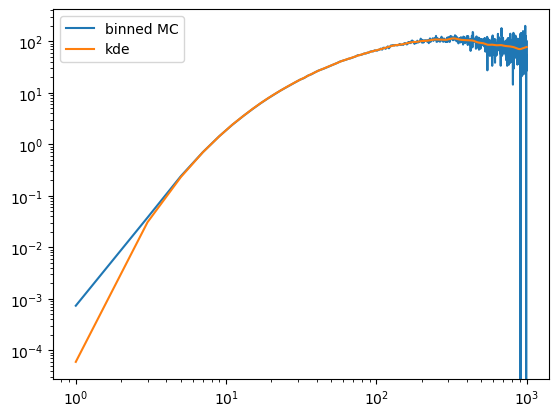

In [18]:
nu = 'nu_e'
Eff_kde_E = Resp_KDE['nu_e'].sum(axis=(0,2,3))
Eff_MC_E = Eff_MC['nu_e'].sum(axis=0)
plt.plot(Bin['true_energy_center'], Eff_MC_E, label='binned MC')
plt.plot(Bin['true_energy_center'], Eff_kde_E, label='kde')


plt.semilogy()
plt.semilogx()
plt.legend()

In [13]:
def Resolution(Resp):
    Reso=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}

    for nu_type in nu_types:
        Eff = Resp[nu_type].sum(axis=(2,3))
        Eff = np.repeat(Eff[:, :, np.newaxis], Resp[nu_type].shape[2], axis=(2))
        Eff = np.repeat(Eff[:, :, :, np.newaxis], Resp[nu_type].shape[3], axis=(3))
        Reso[nu_type] = Resp[nu_type]/Eff

    return Reso
        

In [14]:
Reso = Resolution(Resp_KDE)

In [34]:
def PsiReso(Reso, Bin, quantile):
    PsiRes=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    for nu_type in nu_types:
        PsiRes[nu_type] = np.zeros((len(Bin['true_psi_center']), len(quantile)))
        res_psi = Reso[nu_type].sum(axis=(1,3))
        for i in range(len(Bin['true_psi_center'])):
           PsiRes[nu_type][i] = weighted_quantile(Bin['reco_psi_center'], quantile, sample_weight=res_psi[i,:], values_sorted=True)
    return PsiRes       

In [35]:
PsiRes = PsiReso(Reso, Bin, [0.1,0.5,0.9])

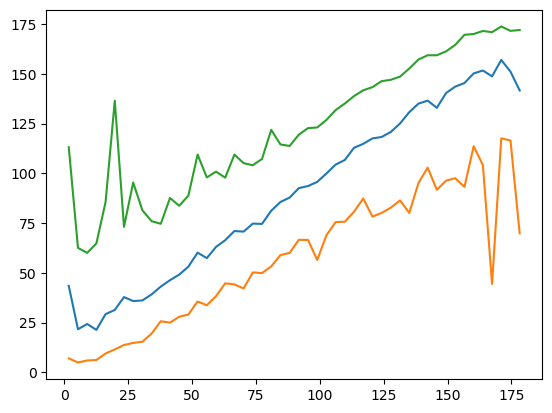

In [37]:
median = [PsiRes['nu_e'][i][1] for i in range(len(Bin['true_psi_center']))]
low = [PsiRes['nu_e'][i][0] for i in range(len(Bin['true_psi_center']))]
up = [PsiRes['nu_e'][i][2] for i in range(len(Bin['true_psi_center']))]

plt.plot(Bin['true_psi_center'], median)
plt.plot(Bin['true_psi_center'], low)
plt.plot(Bin['true_psi_center'], up)